Cell 1: Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")



Cell 2: Load dataset

In [5]:
# Replace "superstore.csv" with your dataset path
df = pd.read_csv("superstore_sales.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-11-08,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-06-12,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-10-11,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-10-11,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Cell 3: Aggregate daily sales

In [6]:
daily_sales = df.set_index('Order Date').resample('D')['Sales'].sum().asfreq('D').fillna(0)
daily_sales.head(10)


,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158
2015-01-08,0.000
2015-01-09,40.544
2015-01-10,54.830
2015-01-11,9.940


ell 4: Stationarity check (ADF test)

In [7]:
result = adfuller(daily_sales)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    series = daily_sales.diff().dropna()
    d = 1
else:
    series = daily_sales
    d = 0


ADF Statistic: -4.926583375196239
p-value: 3.094891245873596e-05


Cell 5: Train/Test Split

In [8]:
test_days = 30
train = series[:-test_days]
test = series[-test_days:]
print("Train length:", len(train), "Test length:", len(test))


Train length: 1428 Test length: 30


Cell 6: Fit SARIMA

In [9]:
model = SARIMAX(train, order=(1,d,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1428
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -12927.810
Date:                           Fri, 03 Oct 2025   AIC                          25865.620
Time:                                   10:57:33   BIC                          25891.916
Sample:                               01-03-2015   HQIC                         25875.443
                                    - 11-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.004    236.732      0.000       0.992       1.008
ma.L1         -0.9991      0.011    -90.906

Cell 7: Predictions on Test Set

In [10]:
preds = model_fit.predict(start=test.index[0], end=test.index[-1])

if d == 1:
    preds = preds.cumsum() + daily_sales.loc[train.index[-1]]
    test = daily_sales.loc[test.index]

rmse = np.sqrt(mean_squared_error(test, preds))
print("Test RMSE:", rmse)


Test RMSE: 2407.7059385852713


Cell 8: Forecast Next 30 Days

In [11]:
forecast = model_fit.get_forecast(steps=30).predicted_mean

if d == 1:
    forecast = forecast.cumsum() + daily_sales.iloc[-1]

future_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast = pd.Series(forecast.values, index=future_index)
forecast.head()


,0
2018-12-31,2714.907151
2019-01-01,2373.299929
2019-01-02,2522.435462
2019-01-03,2251.710329
2019-01-04,2593.472642


Cell 9: Visualization

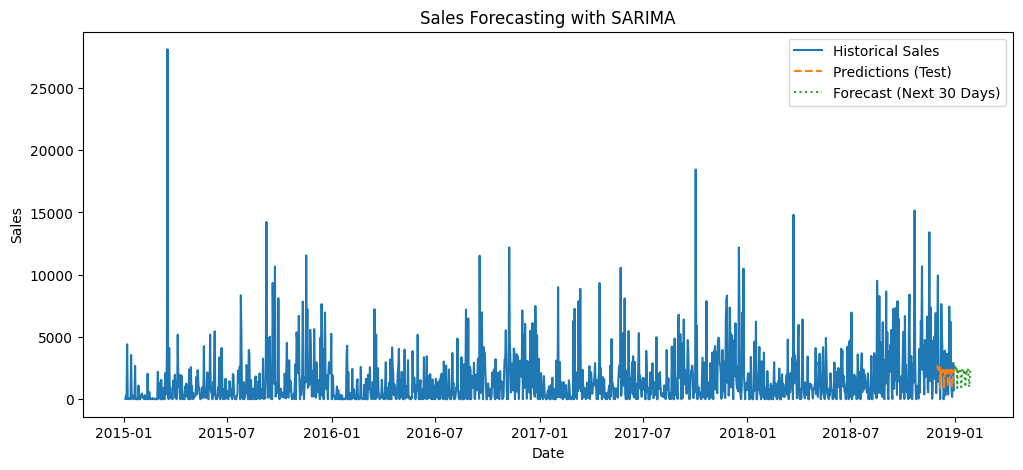

In [12]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales, label='Historical Sales')
plt.plot(test.index, preds, label='Predictions (Test)', linestyle='--')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 Days)', linestyle=':')
plt.legend()
plt.title('Sales Forecasting with SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()
